# HAR CNN training 

In [1]:
# Imports
import numpy as np
import os
from utils.utilities import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

## Prepare data

In [2]:
X, labels,  = read_data(data_path="./data/", split="train") # train
X_train,X_test, labels_train, labels_test = train_test_split(X, labels, test_size = 0.2, random_state = 0)  


In [3]:
X_train, X_test = standardize(X_train, X_test)

Train/Validation Split

In [4]:
X_tr, X_vld, lab_tr, lab_vld = train_test_split(X_train, labels_train, 
                                                stratify = labels_train, random_state = 123)

One-hot encoding:

In [5]:
y_tr = one_hot(lab_tr)
y_vld = one_hot(lab_vld)
y_test = one_hot(labels_test)

In [6]:
# Imports
import tensorflow as tf

### Hyperparameters

In [15]:
batch_size = 491     # Batch size
seq_len = 3000         # Number of steps
learning_rate = 0.001
epochs = 1000

n_classes = 6
n_channels = 1

### Construct the graph
Placeholders

In [16]:
graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len,1], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

Build Convolutional Layers

Note: Should we use a different activation? Like tf.nn.tanh?

In [17]:
with graph.as_default():
    # (batch, 3000, 1) --> (batch, 750, 18)
    conv1 = tf.layers.conv1d(inputs=inputs_, filters=18, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=4, strides=4, padding='same')
    
    # (batch, 750, 18) --> (batch, 150, 36)
    conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=36, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=5, strides=5, padding='same')
    
    # (batch, 150, 36) --> (batch, 30, 72)
    conv3 = tf.layers.conv1d(inputs=max_pool_2, filters=72, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=5, strides=5, padding='same')

Now, flatten and pass to the classifier

In [18]:
with graph.as_default():
    # Flatten and add dropout
    flat = tf.reshape(max_pool_3, (-1, 30*72))
    flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
    
    # Predictions
    logits = tf.layers.dense(flat, n_classes)
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

### Train the network

In [19]:
if (os.path.exists('checkpoints-cnn') == False):
    !mkdir checkpoints-cnn

In [20]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 10 iterations
            if (iteration%10 == 0):                
                val_acc_ = []
                val_loss_ = []
                
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0}  
                    
                    # Loss
                    loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    
    saver.save(sess,"checkpoints-cnn/har.ckpt")

Epoch: 4/1000 Iteration: 5 Train loss: 0.933012 Train acc: 0.757638
Epoch: 9/1000 Iteration: 10 Train loss: 0.911482 Train acc: 0.763747
Epoch: 9/1000 Iteration: 10 Validation loss:    nan Validation acc: nan


/Users/zl-mac/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/zl-mac/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch: 14/1000 Iteration: 15 Train loss: 0.818641 Train acc: 0.767821
Epoch: 19/1000 Iteration: 20 Train loss: 0.780838 Train acc: 0.773931
Epoch: 19/1000 Iteration: 20 Validation loss:    nan Validation acc: nan
Epoch: 24/1000 Iteration: 25 Train loss: 0.729767 Train acc: 0.771894
Epoch: 29/1000 Iteration: 30 Train loss: 0.702380 Train acc: 0.767821
Epoch: 29/1000 Iteration: 30 Validation loss:    nan Validation acc: nan
Epoch: 34/1000 Iteration: 35 Train loss: 0.672469 Train acc: 0.778004
Epoch: 39/1000 Iteration: 40 Train loss: 0.673438 Train acc: 0.790224
Epoch: 39/1000 Iteration: 40 Validation loss:    nan Validation acc: nan
Epoch: 44/1000 Iteration: 45 Train loss: 0.647145 Train acc: 0.784114
Epoch: 49/1000 Iteration: 50 Train loss: 0.635431 Train acc: 0.782077
Epoch: 49/1000 Iteration: 50 Validation loss:    nan Validation acc: nan
Epoch: 54/1000 Iteration: 55 Train loss: 0.627004 Train acc: 0.788187
Epoch: 59/1000 Iteration: 60 Train loss: 0.586239 Train acc: 0.794297
Epoch: 5

Epoch: 394/1000 Iteration: 395 Train loss: 0.322839 Train acc: 0.879837
Epoch: 399/1000 Iteration: 400 Train loss: 0.327428 Train acc: 0.849287
Epoch: 399/1000 Iteration: 400 Validation loss:    nan Validation acc: nan
Epoch: 404/1000 Iteration: 405 Train loss: 0.329591 Train acc: 0.865580
Epoch: 409/1000 Iteration: 410 Train loss: 0.325936 Train acc: 0.865580
Epoch: 409/1000 Iteration: 410 Validation loss:    nan Validation acc: nan
Epoch: 414/1000 Iteration: 415 Train loss: 0.335705 Train acc: 0.853360
Epoch: 419/1000 Iteration: 420 Train loss: 0.322496 Train acc: 0.879837
Epoch: 419/1000 Iteration: 420 Validation loss:    nan Validation acc: nan
Epoch: 424/1000 Iteration: 425 Train loss: 0.346715 Train acc: 0.867617
Epoch: 429/1000 Iteration: 430 Train loss: 0.334746 Train acc: 0.865580
Epoch: 429/1000 Iteration: 430 Validation loss:    nan Validation acc: nan
Epoch: 434/1000 Iteration: 435 Train loss: 0.333496 Train acc: 0.867617
Epoch: 439/1000 Iteration: 440 Train loss: 0.330802 

Epoch: 774/1000 Iteration: 775 Train loss: 0.280531 Train acc: 0.881874
Epoch: 779/1000 Iteration: 780 Train loss: 0.269988 Train acc: 0.896130
Epoch: 779/1000 Iteration: 780 Validation loss:    nan Validation acc: nan
Epoch: 784/1000 Iteration: 785 Train loss: 0.283124 Train acc: 0.883910
Epoch: 789/1000 Iteration: 790 Train loss: 0.286814 Train acc: 0.881874
Epoch: 789/1000 Iteration: 790 Validation loss:    nan Validation acc: nan
Epoch: 794/1000 Iteration: 795 Train loss: 0.270526 Train acc: 0.892057
Epoch: 799/1000 Iteration: 800 Train loss: 0.273597 Train acc: 0.896130
Epoch: 799/1000 Iteration: 800 Validation loss:    nan Validation acc: nan
Epoch: 804/1000 Iteration: 805 Train loss: 0.285030 Train acc: 0.877800
Epoch: 809/1000 Iteration: 810 Train loss: 0.282367 Train acc: 0.887984
Epoch: 809/1000 Iteration: 810 Validation loss:    nan Validation acc: nan
Epoch: 814/1000 Iteration: 815 Train loss: 0.288433 Train acc: 0.881874
Epoch: 819/1000 Iteration: 820 Train loss: 0.270656 

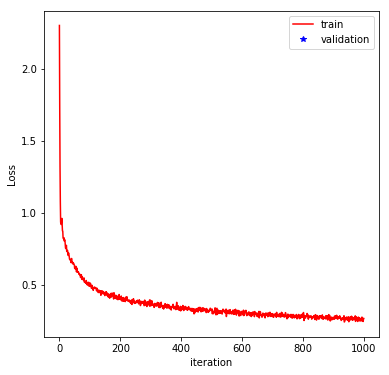

In [21]:
# Plot training and test loss
t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 10 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

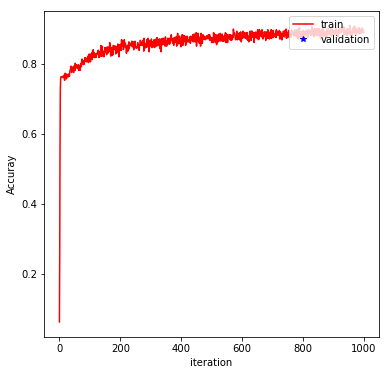

In [22]:
# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 10 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Evaluate on test set

In [25]:
test_acc = []

with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-cnn'))
    
    for x_t, y_t in get_batches(X_test, y_test, batch_size):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 0}
        
        batch_acc = sess.run(accuracy, feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints-cnn/har.ckpt
Test accuracy: nan


/Users/zl-mac/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/zl-mac/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
